# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to **aggregate the observations on an interval of 38 minutes**. For this time interval, using the values of the **9 previous time intervals**, forecast the target value one step in the future. Choose which features you are going to use.

**You must train an LSTM network.**



Features:

* TimePeriod: Time window of ten minutes.
* WT: Weather Temperature.
* WH: Weather Humidity.
* WS: Wind Speed.
* GDF: General Diffuse Flow. “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DF: DiffuseFlows

Target:

Consumption

## Dateset links:
 * [DS1](https://drive.google.com/file/d/1-8neeIpiq6yzWVw4EG_WgzHX4kPH1n1j/view?usp=sharing)
 * [DS2](https://drive.google.com/file/d/1-LhrUaH59q8O0SYB8WE-Eov2gaTMQYVx/view?usp=sharing)

## Read the datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Input, Dense, LSTM, Embedding, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
df1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/power_consumption_g2.csv')

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/power_consumption_g2_feat.csv')

In [ ]:
df1

,TimePeriod,Consumption
0,2017-12-02 20:10:00,36824.33460
1,2017-12-25 15:30:00,31841.82510
2,2017-05-19 21:10:00,44909.11475
3,2017-05-28 04:50:00,22964.45902
4,2017-05-08 16:10:00,33829.77049
...,...,...
52411,2017-10-01 23:50:00,31138.03063
52412,2017-12-07 17:40:00,40091.25475
52413,2017-09-11 18:30:00,38930.97345
52414,2017-04-16 04:50:00,23734.42411


In [ ]:
df2

,TimePeriod,WT,WH,WS,GDF,DF
0,2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300
1,2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630
2,2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322
3,2017-02-10 06:50:00,12.25,80.80,4.916,0.051,0.111
4,2017-03-06 16:00:00,15.62,59.38,0.075,533.400,579.900
...,...,...,...,...,...,...
52411,2017-05-14 02:20:00,23.58,43.10,0.075,0.110,0.122
52412,2017-11-17 19:20:00,17.30,76.50,0.075,0.040,0.148
52413,2017-03-21 12:10:00,17.90,50.28,0.081,837.000,296.700
52414,2017-07-28 05:10:00,25.23,61.32,4.907,0.091,0.119


## Merge the datasets (and pre-process if needed)

In [ ]:
df1.isna().sum()

TimePeriod     0
Consumption    0
dtype: int64

In [ ]:
df2.isna().sum()

TimePeriod      0
WT            559
WH            499
WS            529
GDF           524
DF            505
dtype: int64

In [ ]:
df2.ffill().isna().sum()

TimePeriod    0
WT            0
WH            0
WS            0
GDF           0
DF            0
dtype: int64

In [ ]:
df2.sort_values('TimePeriod')

,TimePeriod,WT,WH,WS,GDF,DF
37462,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119
37635,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085
19407,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100
17609,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096
27906,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085
...,...,...,...,...,...,...
22761,2017-12-30 23:10:00,7.010,72.4,0.080,NaN,0.096
45762,2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093
13568,2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074
23742,2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089


In [ ]:
df1 = df1.sort_values('TimePeriod')

In [ ]:
df2 = df2.sort_values('TimePeriod')

In [ ]:
df1

,TimePeriod,Consumption
22869,2017-01-01 00:00:00,34055.69620
5406,2017-01-01 00:10:00,29814.68354
46586,2017-01-01 00:20:00,29128.10127
29105,2017-01-01 00:30:00,28228.86076
45564,2017-01-01 00:40:00,27335.69620
...,...,...
43715,2017-12-30 23:10:00,31160.45627
23849,2017-12-30 23:20:00,30430.41825
3466,2017-12-30 23:30:00,29590.87452
11824,2017-12-30 23:40:00,28958.17490


In [ ]:
df2

,TimePeriod,WT,WH,WS,GDF,DF
37462,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119
37635,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085
19407,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100
17609,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096
27906,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085
...,...,...,...,...,...,...
22761,2017-12-30 23:10:00,7.010,72.4,0.080,NaN,0.096
45762,2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093
13568,2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074
23742,2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089


In [ ]:
df2['TimePeriod'] = pd.to_datetime(df2['TimePeriod'])

In [ ]:
df2

,TimePeriod,WT,WH,WS,GDF,DF
37462,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119
37635,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085
19407,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100
17609,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096
27906,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085
...,...,...,...,...,...,...
22761,2017-12-30 23:10:00,7.010,72.4,0.080,NaN,0.096
45762,2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093
13568,2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074
23742,2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089


In [ ]:
df1

,TimePeriod,Consumption
22869,2017-01-01 00:00:00,34055.69620
5406,2017-01-01 00:10:00,29814.68354
46586,2017-01-01 00:20:00,29128.10127
29105,2017-01-01 00:30:00,28228.86076
45564,2017-01-01 00:40:00,27335.69620
...,...,...
43715,2017-12-30 23:10:00,31160.45627
23849,2017-12-30 23:20:00,30430.41825
3466,2017-12-30 23:30:00,29590.87452
11824,2017-12-30 23:40:00,28958.17490


## Group the datasets into time intervals of 1 hour

In [ ]:
df1['TimePeriod'] = pd.to_datetime(df1['TimePeriod'])
df1 = df1.groupby(pd.Grouper(key='TimePeriod',freq='1h')).mean()

In [ ]:
df2 = df2.groupby(pd.Grouper(key='TimePeriod', freq='1h')).mean()

In [ ]:
df = df2.merge(df1,how='left', right_index=True, left_index=True)

In [ ]:
df

,WT,WH,WS,GDF,DF,Consumption
TimePeriod,,,,,,
2017-01-01 00:00:00,6.265600,75.066667,0.081833,0.063500,0.098833,29197.974683
2017-01-01 01:00:00,5.548833,77.460000,0.082000,0.056833,0.112500,24657.215190
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367
...,...,...,...,...,...,...
2017-12-30 19:00:00,9.453333,62.538000,0.074667,0.052000,0.102000,37513.814957
2017-12-30 20:00:00,9.041667,63.990000,0.080333,0.052667,0.105000,37008.871988
2017-12-30 21:00:00,8.011667,69.675000,0.081500,0.073167,0.098333,35358.174905


## Create lags

In [ ]:
cols = list(df.columns)

In [ ]:
cols

['WT', 'WH', 'WS', 'GDF', 'DF', 'Consumption']

In [ ]:
lags = 9

In [ ]:
for i in range(1,lags+1):
  for col in cols:
    df[f'{col}_lag_{i}'] = df[col].shift(i)

In [ ]:
df = df.dropna()

In [ ]:
df

,WT,WH,WS,GDF,DF,Consumption,WT_lag_1,WH_lag_1,WS_lag_1,GDF_lag_1,...,WS_lag_8,GDF_lag_8,DF_lag_8,Consumption_lag_8,WT_lag_9,WH_lag_9,WS_lag_9,GDF_lag_9,DF_lag_9,Consumption_lag_9
TimePeriod,,,,,,,,,,,,,,,,,,,,,
2017-01-01 09:00:00,4.609167,73.983333,0.082167,144.800000,25.215000,22905.316455,4.655167,73.600000,0.082667,13.763833,...,0.082000,0.056833,0.112500,24657.215190,6.265600,75.066667,0.081833,0.063500,0.098833,29197.974683
2017-01-01 10:00:00,6.145333,69.635000,3.738500,293.266667,31.875000,26685.569620,4.609167,73.983333,0.082167,144.800000,...,0.082333,0.063000,0.129167,22083.037973,5.548833,77.460000,0.082000,0.056833,0.112500,24657.215190
2017-01-01 11:00:00,9.893333,58.036667,2.088167,409.440000,36.341667,29288.101265,6.145333,69.635000,3.738500,293.266667,...,0.082833,0.059833,0.141000,20811.139240,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973
2017-01-01 12:00:00,14.846667,57.078333,0.075667,478.850000,40.201667,29889.620255,9.893333,58.036667,2.088167,409.440000,...,0.082333,0.058000,0.122833,20475.949367,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240
2017-01-01 13:00:00,15.680000,57.071667,0.076667,493.933333,41.761667,30231.898735,14.846667,57.078333,0.075667,478.850000,...,0.081000,0.065833,0.118833,20807.088607,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 19:00:00,9.453333,62.538000,0.074667,0.052000,0.102000,37513.814957,10.771667,58.323333,0.076500,3.185833,...,0.077667,413.550000,37.781667,30450.697085,12.958333,44.521667,0.076333,293.333333,34.770000,28848.669200
2017-12-30 20:00:00,9.041667,63.990000,0.080333,0.052667,0.105000,37008.871988,9.453333,62.538000,0.074667,0.052000,...,0.078000,482.016667,38.356667,30621.039290,13.806667,42.128333,0.077667,413.550000,37.781667,30450.697085
2017-12-30 21:00:00,8.011667,69.675000,0.081500,0.073167,0.098333,35358.174905,9.041667,63.990000,0.080333,0.052667,...,0.077333,497.666667,38.553333,30359.442335,14.300000,39.181667,0.078000,482.016667,38.356667,30621.039290


## Split the dataset into 80% training and 20% testing datasets


In [ ]:
X, Y = df.drop(columns=cols,axis=1), df['Consumption']

In [ ]:
X

,WT_lag_1,WH_lag_1,WS_lag_1,GDF_lag_1,DF_lag_1,Consumption_lag_1,WT_lag_2,WH_lag_2,WS_lag_2,GDF_lag_2,...,WS_lag_8,GDF_lag_8,DF_lag_8,Consumption_lag_8,WT_lag_9,WH_lag_9,WS_lag_9,GDF_lag_9,DF_lag_9,Consumption_lag_9
TimePeriod,,,,,,,,,,,,,,,,,,,,,
2017-01-01 09:00:00,4.655167,73.600000,0.082667,13.763833,6.308667,19605.063290,4.453833,73.400000,0.082667,0.065500,...,0.082000,0.056833,0.112500,24657.215190,6.265600,75.066667,0.081833,0.063500,0.098833,29197.974683
2017-01-01 10:00:00,4.609167,73.983333,0.082167,144.800000,25.215000,22905.316455,4.655167,73.600000,0.082667,13.763833,...,0.082333,0.063000,0.129167,22083.037973,5.548833,77.460000,0.082000,0.056833,0.112500,24657.215190
2017-01-01 11:00:00,6.145333,69.635000,3.738500,293.266667,31.875000,26685.569620,4.609167,73.983333,0.082167,144.800000,...,0.082833,0.059833,0.141000,20811.139240,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973
2017-01-01 12:00:00,9.893333,58.036667,2.088167,409.440000,36.341667,29288.101265,6.145333,69.635000,3.738500,293.266667,...,0.082333,0.058000,0.122833,20475.949367,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240
2017-01-01 13:00:00,14.846667,57.078333,0.075667,478.850000,40.201667,29889.620255,9.893333,58.036667,2.088167,409.440000,...,0.081000,0.065833,0.118833,20807.088607,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 19:00:00,10.771667,58.323333,0.076500,3.185833,3.251500,37929.531053,13.775000,44.448333,0.077833,81.493333,...,0.077667,413.550000,37.781667,30450.697085,12.958333,44.521667,0.076333,293.333333,34.770000,28848.669200
2017-12-30 20:00:00,9.453333,62.538000,0.074667,0.052000,0.102000,37513.814957,10.771667,58.323333,0.076500,3.185833,...,0.078000,482.016667,38.356667,30621.039290,13.806667,42.128333,0.077667,413.550000,37.781667,30450.697085
2017-12-30 21:00:00,9.041667,63.990000,0.080333,0.052667,0.105000,37008.871988,9.453333,62.538000,0.074667,0.052000,...,0.077333,497.666667,38.553333,30359.442335,14.300000,39.181667,0.078000,482.016667,38.356667,30621.039290


In [ ]:
Y

TimePeriod
2017-01-01 09:00:00    22905.316455
2017-01-01 10:00:00    26685.569620
2017-01-01 11:00:00    29288.101265
2017-01-01 12:00:00    29889.620255
2017-01-01 13:00:00    30231.898735
                           ...     
2017-12-30 19:00:00    37513.814957
2017-12-30 20:00:00    37008.871988
2017-12-30 21:00:00    35358.174905
2017-12-30 22:00:00    33993.409380
2017-12-30 23:00:00    30107.984788
Name: Consumption, Length: 8710, dtype: float64

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

## Create the model, pre-process the data and make it suitable for training

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))

In [ ]:
X_train.shape

(6968, 54)

The shape should be [samples, timesteps, features]



In [ ]:
lag = 9

# Reshape the training and test data to include all 9 lags
X_train = X_train.reshape(X_train.shape[0], lag, X_train.shape[1] // lag)
X_test = X_test.reshape(X_test.shape[0], lag, X_test.shape[1] // lag)

# Update input shape for the LSTM layer
input_shape = (X_train.shape[1], X_train.shape[2])

# Now your input shape will be (9, 6) assuming X_train.shape[1] = 54


## Train the model, use 20% of the training dataset for validation
Train with 10 epochs (due to time limit)

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=input_shape, return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()])
history = model.fit(X_train, Y_train, batch_size=16, validation_split=0.2, epochs=10, shuffle=False)


Epoch 1/10
349/349 [==============================] - 7s 13ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1104 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0718
Epoch 2/10
349/349 [==============================] - 5s 13ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0707 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0631
Epoch 3/10
349/349 [==============================] - 5s 13ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0603 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0528
Epoch 4/10
349/349 [==============================] - 4s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0514 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0463
Epoch 5/10
349/349 [==============================] - 5s 13ms/step - loss: 0.0034 - mean_squ

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 100)            42800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 73051 (285.36 KB)
Trainable params: 73051 (285.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Plot the loss function on the training and validation dataset

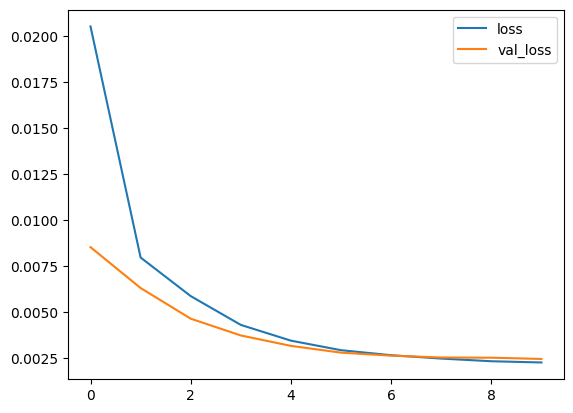

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Calculate the adequate metrics

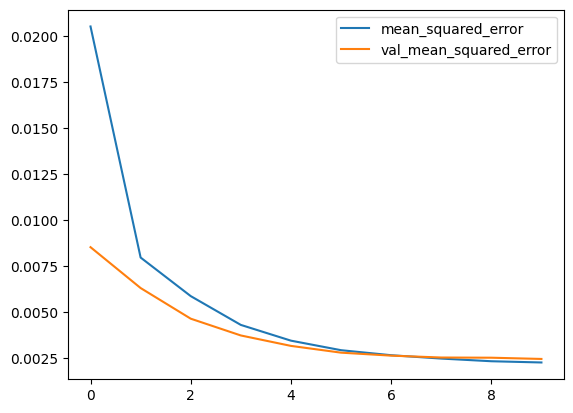

In [ ]:
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.legend()
plt.show()

In [ ]:
preds = model.predict(X_test)

55/55 [==============================] - 1s 4ms/step


In [ ]:
preds = scaler.inverse_transform(preds)

In [ ]:
mean_squared_error(preds, Y_test), mean_absolute_error(preds, Y_test), r2_score(preds, Y_test)

(7991545.338983507, 2520.4457245555873, 0.717834243358219)

## Visualize the targets against the predictions

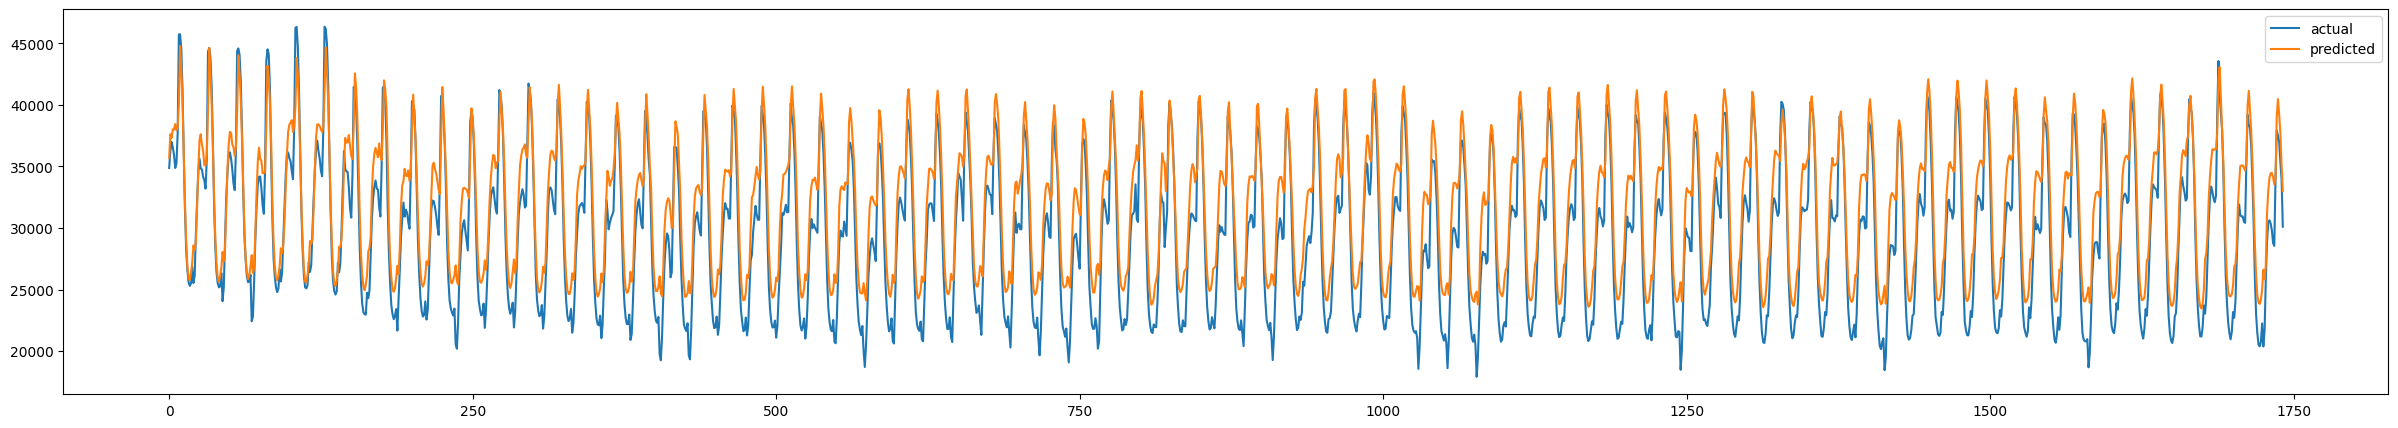

In [ ]:
plt.figure(figsize=(30, 5))
plt.plot(Y_test.values, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()